# Imports and Dependencies

In [ ]:
import os
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/Drone_Recog/")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model, to_categorical, image_dataset_from_directory
from tensorflow.keras import optimizers

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import base64
import cv2
import io

In [ ]:
h, w = 240, 360 #180, 320
epochs = 500
frame_seq = 25
vid_path = 'OP_Results/vid_result'

class_names = os.listdir(vid_path)
num_class = len(class_names)

# Preparing Dataset

In [ ]:
def get_frames(path):
    """
    Function extracts frames of video after it is resize and normalized
    in the form of a list.
    :param path: path of video
    :return: list of frames of every video
    """

    frame_list = []

    # set capture object and count frames
    vid_reader = cv2.VideoCapture(path)
    frame_count = int(vid_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_skip = max(int(frame_count / frame_seq), 1)

    # extracting frames
    for i in range(frame_seq):
        # skip a couple of frames (don't need everything)
        vid_reader.set(cv2.CAP_PROP_POS_FRAMES, i * frame_skip)
        success, frame = vid_reader.read()
        # if no more frames, finish
        if not success:
            break
        resized_frame = cv2.resize(frame, (w, h))
        #normalized_frame = resized_frame / 255
        frame_list.append(resized_frame)
    vid_reader.release()  # release object

    return frame_list

In [ ]:
feature = []
labels = []

for idx, class_name in enumerate(class_names):
    print(f'Extracting Data from: {class_name}')  # show progress
    files = os.listdir(os.path.join(vid_path, class_name))
    for name in files:
        print(f'Extracting Data from: {name}')
        path = os.path.join(vid_path, class_name, name)
        frames = get_frames(path)
        if len(frames) == frame_seq:
            feature.append(frames)
            labels.append(idx)

In [ ]:
# converting to array
feature = np.asarray(feature)
labels = np.array(labels)

print(feature.shape)
print(labels.shape)

(40, 25, 240, 360, 3)
(40,)


In [ ]:
# saving to numpy arrays
if not os.path.exists('OP_Results/image_array'):
    os.makedirs('OP_Results/image_array')
    print("Created new directory 'image_array'")
np.save(f'OP_Results/image_array/{h}x{w}_features_25', feature)
np.save(f'OP_Results/image_array/{h}x{w}_labels_25', labels)

# Plotting

In [ ]:
def plot_graph(training_history, metric1, metric2, plot_name):
    """
    Function to plot and show graph of accuracy and loss
    :param training_history: record of training and validation (acc/loss)
    :param metric1: first metric
    :param metric2: second metric
    :param plot_name: name of plot
    """

    # Get metric values using metric names as identifiers.
    metric_1 = training_history.history[metric1]
    metric_2 = training_history.history[metric2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_1))

    # Plotting
    plt.plot(epochs, metric_1, 'blue', label=metric1)
    plt.plot(epochs, metric_2, 'red', label=metric2)

    # Add title
    plt.title(str(plot_name))

    # Legends
    plt.legend()
    plt.show()

# Model

In [ ]:
# 3D CNN
def build_3DConv():
    In = Input(shape=(frame_seq, h, w, 3), name='3DCNN_Input')
    x = Conv3D(32, (3, 3, 3), strides=(1, 2, 2), padding='same', activation='relu', name='conv3d_1a')(In)
    x = Conv3D(32, (3, 3, 3), strides=(1, 2, 2), padding='same', activation='relu', name='conv3d_1b')(x)
    x = MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name='pool_1')(x)
    x = Conv3D(64, (3, 3, 3), padding='same', activation='relu', name='conv3d_2a')(x)
    x = Conv3D(64, (3, 3, 3), padding='same', activation='relu', name='conv3d_2b')(x)
    x = MaxPooling3D(pool_size=(1, 2, 2), strides=(2, 2, 2), name='pool_2')(x)
    x = Conv3D(128, (3, 3, 3), padding='same', activation='relu', name='conv3d_3a')(x)
    x = Conv3D(128, (3, 3, 3), padding='same', activation='relu', name='conv3d_3b')(x)
    x = MaxPooling3D(pool_size=(1, 2, 2), strides=(2, 2, 2), name='pool_3')(x)
    x = Conv3D(128, (3, 3, 3), padding='same', activation='relu', name='conv3d_4a')(x)
    x = Conv3D(128, (3, 3, 3), padding='same', activation='relu', name='conv3d_4b')(x)
    x = MaxPooling3D(pool_size=(1, 2, 2), strides=(2, 2, 2), name='pool_4')(x)
    
    return Model(In, x, name = '3DConv')

In [ ]:
# inputs
LRCN_in = Input(shape=(frame_seq, h, w, 3), name = '3DCNN_Input')

# build 3d-cnn
Conv3d = build_3DConv()

# passing input through 3d CNN
cnn_3d = Conv3d(LRCN_in)

Simplified Model

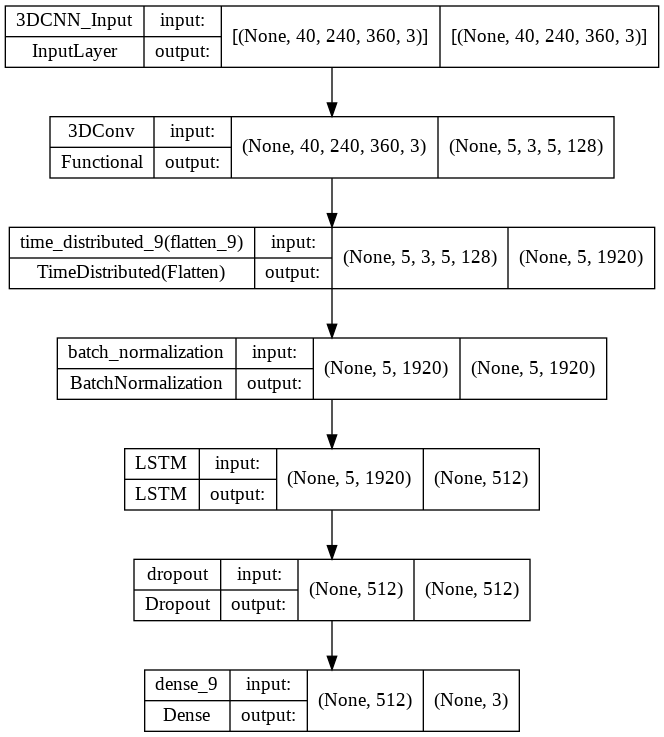

In [ ]:
# LSTM network
x = TimeDistributed(Flatten())(cnn_3d)
x = BatchNormalization(name = 'batch_normalization')(x)
x = tf.keras.layers.LSTM(512, name = 'LSTM')(x)
x = Dropout(0.5, name = 'dropout')(x)
LRCN_out = Dense(num_class, activation = 'softmax')(x)

# build model
LRCN_model = Model(LRCN_in, LRCN_out, name = 'LRCN_Model')
plot_model(LRCN_model, show_shapes = True)

Full Model

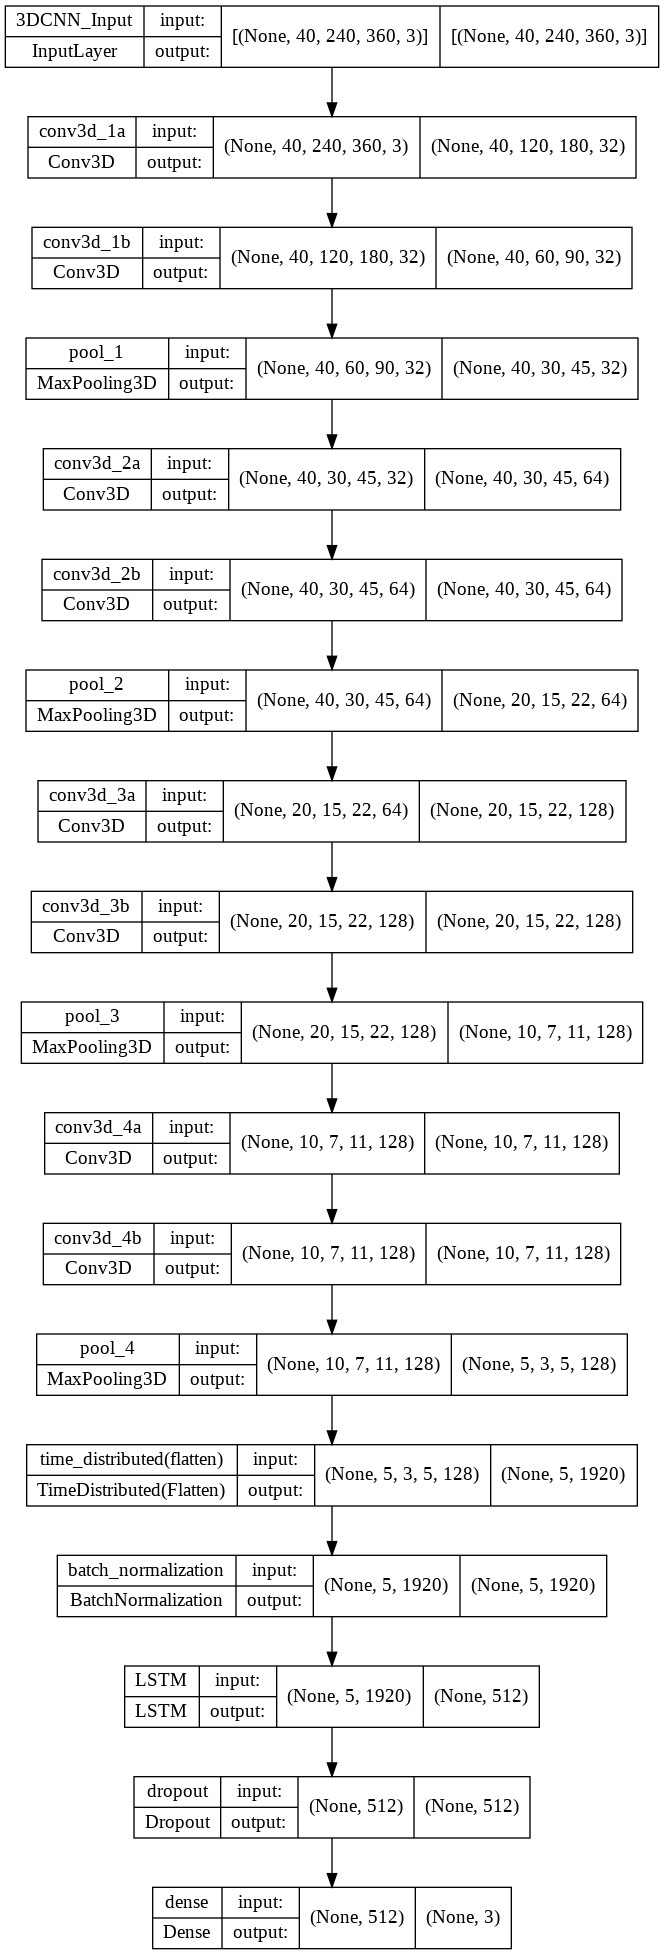

In [ ]:

# 3D CNN network
In = Input(shape=(frame_seq, h, w, 3), name='3DCNN_Input')
x = Conv3D(32, (3, 3, 3), strides=(1, 2, 2), padding='same', activation='relu', name='conv3d_1a')(In)
x = Conv3D(32, (3, 3, 3), strides=(1, 2, 2), padding='same', activation='relu', name='conv3d_1b')(x)
x = MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name='pool_1')(x)
x = Conv3D(64, (3, 3, 3), padding='same', activation='relu', name='conv3d_2a')(x)
x = Conv3D(64, (3, 3, 3), padding='same', activation='relu', name='conv3d_2b')(x)
x = MaxPooling3D(pool_size=(1, 2, 2), strides=(2, 2, 2), name='pool_2')(x)
x = Conv3D(128, (3, 3, 3), padding='same', activation='relu', name='conv3d_3a')(x)
x = Conv3D(128, (3, 3, 3), padding='same', activation='relu', name='conv3d_3b')(x)
x = MaxPooling3D(pool_size=(1, 2, 2), strides=(2, 2, 2), name='pool_3')(x)
x = Conv3D(128, (3, 3, 3), padding='same', activation='relu', name='conv3d_4a')(x)
x = Conv3D(128, (3, 3, 3), padding='same', activation='relu', name='conv3d_4b')(x)
x = MaxPooling3D(pool_size=(1, 2, 2), strides=(2, 2, 2), name='pool_4')(x)

# LSTM network
x = TimeDistributed(Flatten())(x)
x = BatchNormalization(name = 'batch_normalization')(x)
x = tf.keras.layers.LSTM(512, name = 'LSTM')(x)
x = Dropout(0.5, name = 'dropout')(x)
LRCN_out = Dense(num_class, activation = 'softmax')(x)

# build model
LRCN_model = Model(In, LRCN_out, name = 'LRCN_Model')
plot_model(LRCN_model, show_shapes = True)

# Training 

In [ ]:
# Get Dataset
features = np.load(f'OP_Results/image_array/{h}x{w}_features.npy')
labels = np.load(f'OP_Results/image_array/{h}x{w}_labels.npy')

features = features / 255.0
labels = to_categorical(labels, num_classes=num_class)

print(features.shape)
print(labels.shape)

(40, 40, 240, 360, 3)
(40, 3)


In [ ]:
LRCN_model.compile(loss = 'categorical_crossentropy', # measures model accuracy
              optimizer = optimizers.Adam(learning_rate = 0.00001),
              metrics = ['accuracy'])

In [ ]:
# Run Training
LRCN_history = LRCN_model.fit(features, labels,
                              validation_split=0.2,
                              batch_size = 4,
                              epochs=epochs)

In [ ]:
# split datasets for testing
X_train, X_test, Y_train, Y_test = train_test_split(
    features, labels, test_size=0.8, shuffle=True, random_state=123)

In [ ]:
# Evaluate Accuracy
test_loss, test_acc = LRCN_model.evaluate(X_test, Y_test, verbose=2)
print(f'Test Accuracy: {test_acc}')

1/1 - 3s - loss: 6.3908e-05 - accuracy: 1.0000 - 3s/epoch - 3s/step
Test Accuracy: 1.0


In [ ]:
# Debug
LRCN_model.summary()

In [ ]:
# saving model
file_name = f'results/OP_LRCN_model__Loss_{test_loss}__Acc_{test_acc}'
LRCN_model.save(file_name)
# plot model
plot_model(LRCN_model, to_file=f'results/OP_LRCN_model__Loss_{test_loss}__Acc_{test_acc}/LRCN_model.png', 
           show_shapes = True)

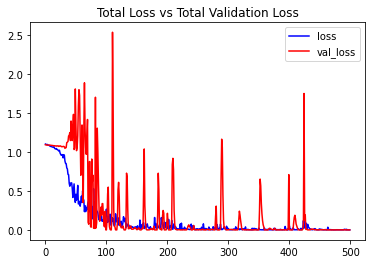

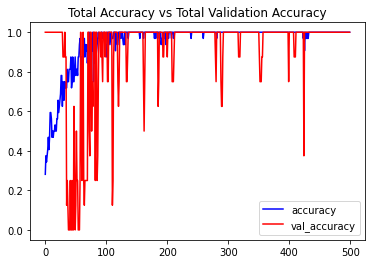

In [ ]:
# plotting loss and accuracy
plot_graph(LRCN_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')
plot_graph(LRCN_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# Testing

Loading Model and Data Prediction

In [ ]:
# model directory
!ls model\ results/Non-3D

1_LRCN_model__Loss_0.8008179068565369__Acc_0.75
2_LRCN_model__Loss_1.6898219585418701__Acc_0.6000000238418579


In [ ]:
# load model
LRCN_model = load_model('model results/Non-3D/1_LRCN_model__Loss_0.8008179068565369__Acc_0.75')

# checking architecture
LRCN_model.summary()

In [ ]:
# get data, OP arrays
OP_features = np.load(f'OP_Results/image_array/{h}x{w}_features_25.npy')
OP_labels = np.load(f'OP_Results/image_array/{h}x{w}_labels_25.npy')
# normal arrays
features = np.load(f'image_array/{h}x{w}_features_test_25.npy')
labels = np.load(f'image_array/{h}x{w}_labels_test_25.npy')

OP_features = OP_features / 255.0
features = features / 255.0
OP_labels = to_categorical(OP_labels, num_classes=num_class)
labels = to_categorical(labels, num_classes=num_class)

In [ ]:
print(OP_features.shape)
print(features.shape)

(40, 25, 240, 360, 3)
(40, 25, 240, 360, 3)


Prediction

In [ ]:
# Prediction: initializing lists for plot
true_lbl = []
prediction, OP_prediction = [], []
predicted_idx, OP_predicted_idx = [], []
predicted_class, OP_predicted_class = [], []
confidence, OP_confidence = [], []

for i in range(len(OP_features)):
    # Get sequence of images 1-by-1
    OP_X = np.expand_dims(OP_features[i], 0)
    X = np.expand_dims(features[i], 0)

    # predict video using model
    OP_prediction.append(LRCN_model.predict(OP_X))
    prediction.append(LRCN_model.predict(X))

    # save prediction idx labels and true labels
    true_lbl.append(np.argmax(OP_labels[i]))
    predicted_idx.append(np.argmax(prediction[i]))
    OP_predicted_idx.append(np.argmax(OP_prediction[i]))

    # save predicted class names
    predicted_class.append(class_names[np.argmax(prediction[i])])
    OP_predicted_class.append(class_names[np.argmax(OP_prediction[i])])

    # confidence for each video in its class
    confidence.append(round(100*np.max(prediction[i]), 2))
    OP_confidence.append(round(100*np.max(OP_prediction[i]), 2))


In [ ]:
print(confidence)
print(OP_confidence)

[60.98, 50.69, 42.7, 79.39, 61.25, 63.09, 40.52, 65.39, 69.3, 75.81, 50.88, 58.79, 53.14, 59.1, 66.66, 51.63, 53.43, 52.69, 50.78, 67.61, 85.68, 95.66, 43.61, 97.91, 97.4, 73.93, 61.45, 95.24, 53.42, 68.93, 90.53, 93.92, 64.55, 96.92, 40.91, 89.03, 83.44, 78.74, 74.52, 72.11]
[51.83, 59.4, 57.71, 76.12, 65.82, 66.65, 66.44, 52.6, 50.98, 50.64, 60.1, 69.41, 76.47, 70.01, 62.55, 56.69, 76.82, 51.32, 42.93, 69.21, 48.6, 98.68, 76.37, 97.18, 96.2, 49.19, 71.97, 51.78, 64.71, 70.27, 36.46, 67.88, 54.81, 99.26, 99.21, 95.92, 46.83, 58.59, 61.82, 97.5]


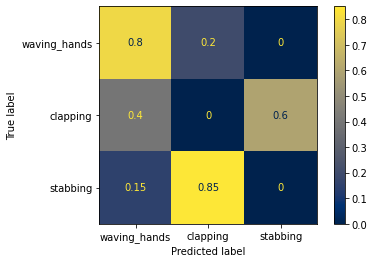

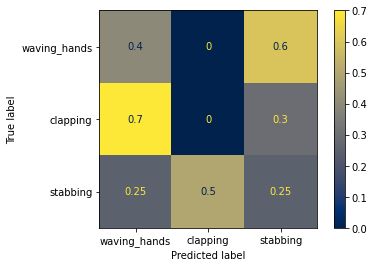

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

pred = ConfusionMatrixDisplay.from_predictions(
    true_lbl,
    predicted_idx,
    display_labels = class_names,
    normalize = 'true',
    include_values = True,
    cmap = plt.cm.cividis,
    colorbar = True
)

OP_pred = ConfusionMatrixDisplay.from_predictions(
    true_lbl,
    OP_predicted_idx,
    display_labels = class_names,
    normalize = 'true',
    include_values = True,
    cmap = plt.cm.cividis,
    colorbar = True
)
plt.show()

In [ ]:
print(classification_report(true_lbl, 
                            predicted_idx, 
                            target_names = class_names, 
                            digits = 4,
                            zero_division = 0))

print(classification_report(true_lbl, 
                            OP_predicted_idx, 
                            target_names = class_names, 
                            digits = 4,
                            zero_division = 1))

              precision    recall  f1-score   support

waving_hands     0.5333    0.8000    0.6400        10
    clapping     0.0000    0.0000    0.0000        10
    stabbing     0.0000    0.0000    0.0000        20

    accuracy                         0.2000        40
   macro avg     0.1778    0.2667    0.2133        40
weighted avg     0.1333    0.2000    0.1600        40

              precision    recall  f1-score   support

waving_hands     0.2500    0.4000    0.3077        10
    clapping     0.0000    0.0000    0.0000        10
    stabbing     0.3571    0.2500    0.2941        20

    accuracy                         0.2250        40
   macro avg     0.2024    0.2167    0.2006        40
weighted avg     0.2411    0.2250    0.2240        40

